Sales forecasting



In [ ]:
#import basic libary  

import pandas as pd                     # to extract data from dataset(.csv file)
import csv                              #used to read and write to csv files
import numpy as np                      #used to convert input into numpy arrays to be fed to the model
import matplotlib.pyplot as plt         #to plot/visualize sales data and sales forecasting
import tensorflow as tf                 # acts as the framework upon which this model is built
from tensorflow import keras            #defines layers and functions in the model

In [ ]:
# if you run on google cloab with google drive the below code is required and give the permission to the google drive by login
# if you run on your computer then you can skip upto 3 steps
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# after the given permission to access the google drive. take the parth of folder you want to acccess for the training and testing file
file_list = drive.ListFile({'q': "'1dunmclAkReLdNXuv9uDLz3ltIRDt5ePi' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Untitled1.ipynb, id: 1-3NVBT9eqNKF229VLCVBTSBDAFekPAfc
title: Untitled2.ipynb, id: 1dlVQcaPTekfH2zP9l-YHeEAkZvB1I67h
title: sales_date.csv, id: 1sTTj-zlhuoc7X-6Izp5txZ9EKioBr015
title: Untitled0.ipynb, id: 10NV6vgBz3O-mj4pSN6EvQqZZ5ukZUIka
title: train.csv, id: 1qsOod3ijv4MP9yxRrZ-MyIVN9O4xrWIZ
title: stores.csv, id: 1x4SjKTAr3Edw17BoTT8Y3LNPfIyeCIK7
title: test.csv, id: 1RKaW9KCCcj-R_ab8btUBK_wpw1TIQb6o
title: sample_submission.csv, id: 1F4LvSXSMOhk-os8hv76swYE7tPndY7gb
title: Walmart.csv, id: 14oCTFMOK5YMHJMUleGlKGDQnc9FhXAsR
title: features.csv, id: 1LznYtE77_cFF050vlItQXt1Z6hi4fzJx


In [ ]:
#list of all the file in the the above folder mention.
# take the id of that file you want to you for training and tesing and give the name as train.csv and test.csv
train_downloaded = drive.CreateFile({'id': '14oCTFMOK5YMHJMUleGlKGDQnc9FhXAsR'})
train_downloaded.GetContentFile('sales_data.csv')



In [ ]:
df = pd.read_csv('sales_data.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.shape

(6435, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.Date=pd.to_datetime(df.Date) # datetime 

df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
#df['month_quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
#                                     8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'}) 
df['weekday'] = df.Date.dt.weekday

df.drop(['Date'], axis=1, inplace=True) # remove date

In [ ]:
target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]] # feature 
original_df = df.copy(deep=True)

print(features)

['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'weekday']


In [ ]:
df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [ ]:
# numerical and categorical attribute 
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; # nf:numerical variable list / nnf the number / cf: categorical variable list / ncf: that number

for i in range(df[features].shape[1]): # shape[1]:10
    if nu.values[i]<=45:cf.append(nu.index[i]) # If less than 45 (number of stores), categorical / others are numerical
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [ ]:
print(df.info())
print("-------"*30)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   year          6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   weekday       6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB
None
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03 

In [ ]:
#EDA - Exploratory Data Analysis

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


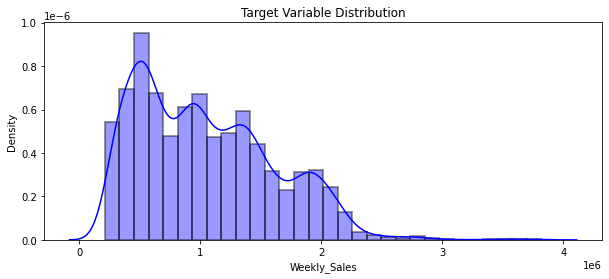

In [ ]:
import seaborn as sns


plt.figure(figsize=[10,4])
sns.distplot(df[target], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution')
plt.show()

                               Visualising Categorical Features:                                


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

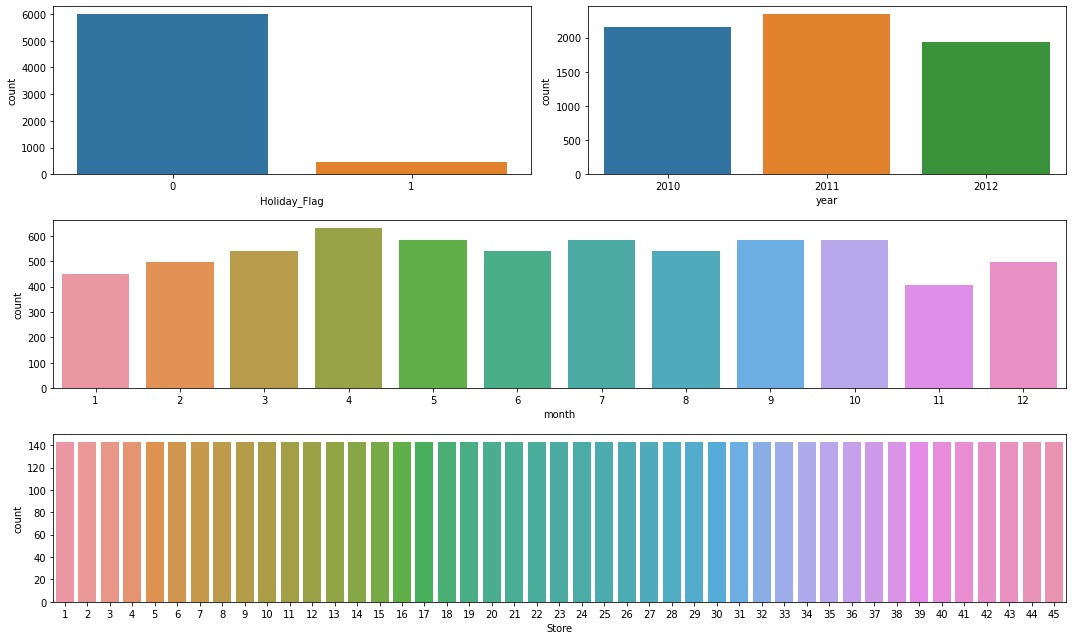

In [ ]:
import math

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                                                Numeric Features Distribution                                                 


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

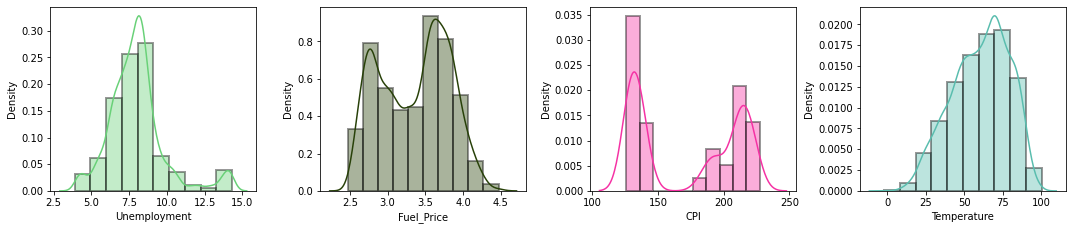

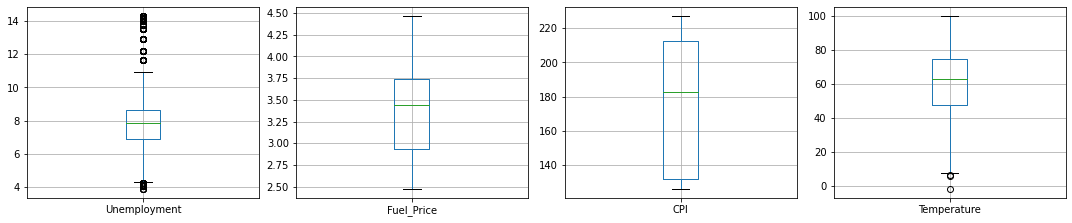

In [ ]:
print('\033[1mNumeric Features Distribution'.center(130))

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

### Data Preprocessing

In [ ]:
# remove duplicate rows
counter = 0
rs,cs = original_df.shape # Tuple type row, column count

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [ ]:
# Null value check
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
year                          0         0.0
month                         0         0.0
weekday                       0         0.0


In [ ]:
# categorical variable encoding

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

oh=True # One-hot encoding
dm=True # dummy encoding

for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
weekday
month
Store


(6435, 69)

In [ ]:
# remove outliers

df1 = df3.copy()

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
    
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


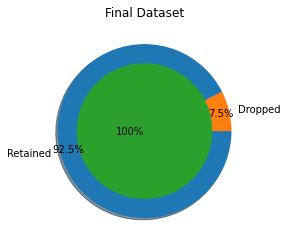


Inference: After the cleanup process, 482 samples were dropped, while retaining 7.49% of the data.


In [ ]:
# Visualize results before and after preprocessing
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

# Data Manipulation

In [ ]:
from sklearn.model_selection import train_test_split

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_')) # pairing of variable names
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 68) (5953,) 
Training set  --->  (4762, 68) (4762,) 
Testing set   --->  (1191, 68)  (1191,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# feature scaling

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,...,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-1.492110e-18,-1.305596e-16,-2.991680e-16,-2.762268e-16,-4.267434e-16,-5.520807e-17,1.939743e-17,4.513632e-17,1.492110e-18,-3.245339e-17,...,1.529413e-17,4.923963e-17,8.952659e-18,1.342899e-17,-3.730275e-18,-1.492110e-17,3.730275e-17,-2.984220e-17,-4.774752e-17,2.499284e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.742012e-01,-2.961575e+00,-1.871814e+00,-1.248731e+00,-2.762670e+00,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
25%,-2.742012e-01,-7.314248e-01,-9.886990e-01,-1.076949e+00,-6.783836e-01,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
50%,-2.742012e-01,1.062547e-01,1.663112e-01,3.842133e-01,9.596435e-02,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
75%,-2.742012e-01,7.731979e-01,8.427860e-01,9.933828e-01,6.138095e-01,1.328679e+00,1.569482e+00,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
max,3.646958e+00,2.170008e+00,2.469806e+00,1.340791e+00,2.575491e+00,1.328679e+00,1.569482e+00,3.863473e+00,8.636394e+00,3.676723e+00,...,6.356783e+00,6.300861e+00,2.298067e+01,6.328643e+00,7.650163e+00,6.503146e+00,6.356783e+00,6.141290e+00,6.443435e+00,6.564495e+00



                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.005646,0.044406,0.075113,0.021041,-0.050953,0.052984,0.065042,0.007679,0.038532,0.026409,...,-0.004168,-0.017693,0.111140,-0.010959,-0.000055,0.030677,-0.004168,-0.056970,0.016556,0.045053
std,1.009885,1.000220,0.971917,1.004644,1.010206,1.014188,1.028250,1.014142,1.152364,1.044095,...,0.987401,0.944330,1.881448,0.965939,1.000214,1.093088,0.987401,0.810380,1.051077,1.134875
min,-0.274201,-2.857425,-1.780457,-1.248731,-2.762670,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
25%,-0.274201,-0.657516,-0.852751,-1.077025,-0.699355,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
50%,-0.274201,0.187351,0.298996,0.393492,0.058860,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
75%,-0.274201,0.818764,0.844961,1.019967,0.611390,1.328679,1.569482,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
max,3.646958,2.035481,2.469806,1.345814,2.575491,1.328679,1.569482,3.863473,8.636394,3.676723,...,6.356783,6.300861,22.980668,6.328643,7.650163,6.503146,6.356783,6.141290,6.443435,6.564495


# Feature selection

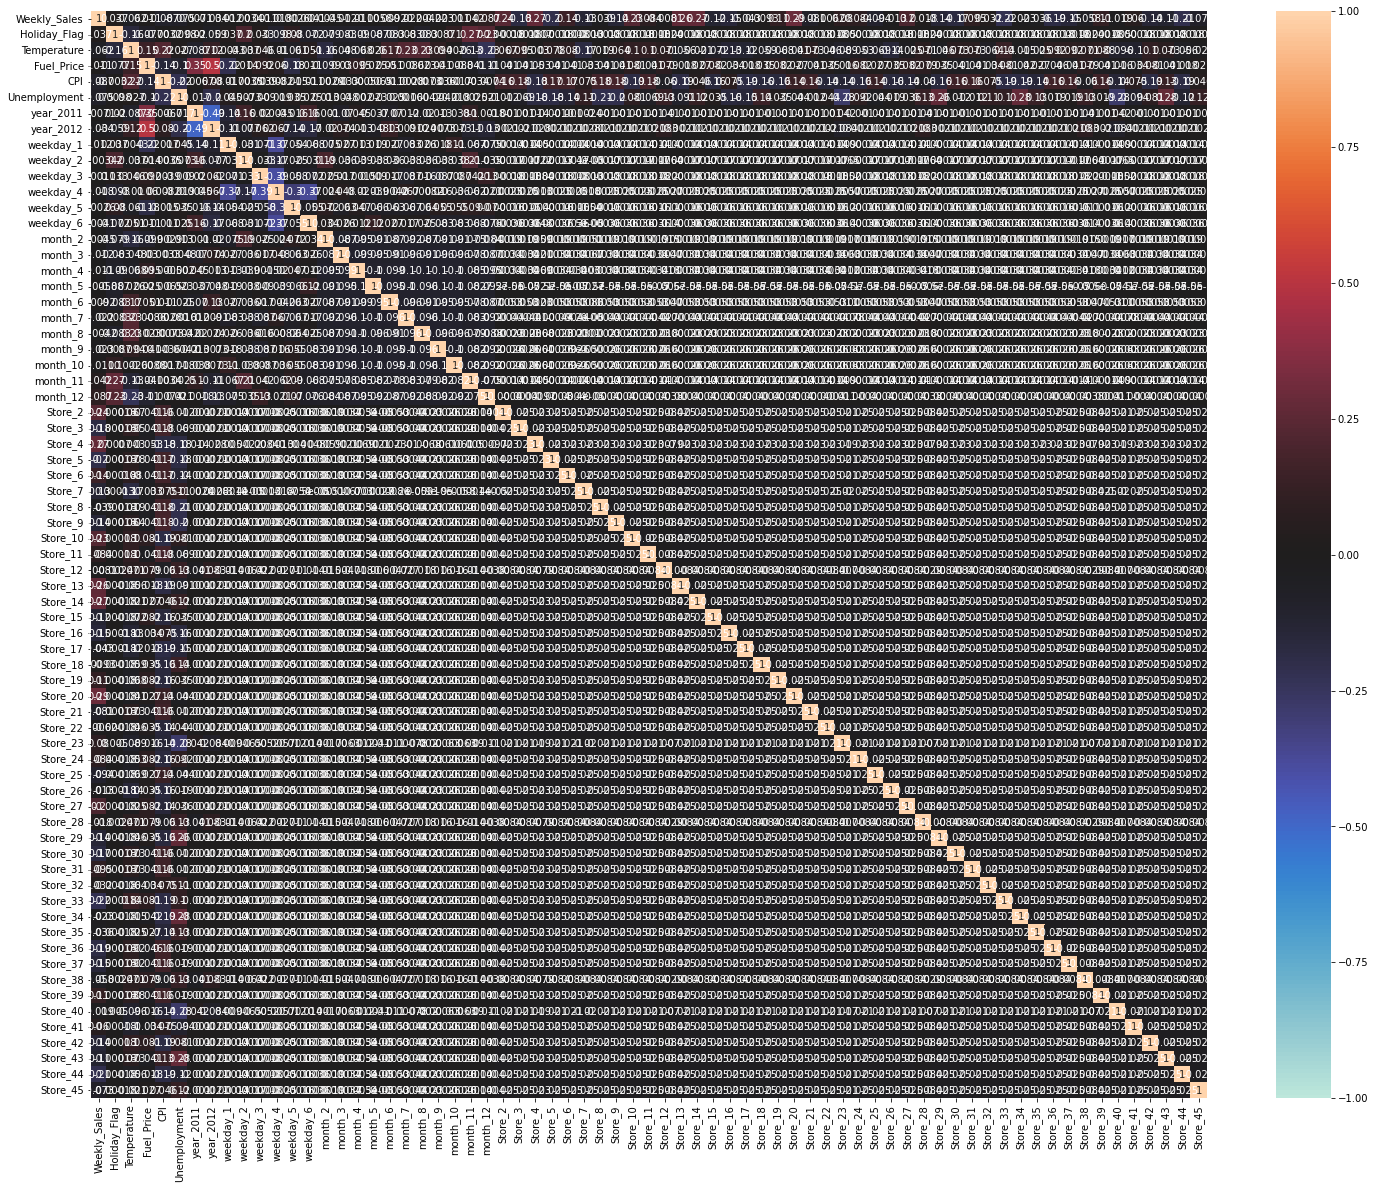

In [ ]:
#heat map

plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

Dropped Features -->  ['CPI', 'Unemployment', 'Fuel_Price', 'weekday_4', 'month_7', 'Store_7', 'Temperature', 'month_12', 'Store_43', 'year_2012', 'Store_30', 'month_2', 'month_11', 'Store_16', 'month_5', 'Store_25', 'Store_29', 'month_10', 'Store_17', 'Holiday_Flag', 'Store_18', 'year_2011', 'Store_19', 'month_9', 'Store_20', 'Store_8', 'Store_34', 'Store_15', 'Store_22', 'month_6', 'Store_21', 'Store_35', 'Store_14', 'Store_13', 'Store_45', 'Store_27', 'month_3', 'weekday_1', 'Store_23', 'Store_44', 'Store_42', 'Store_11', 'weekday_5', 'Store_39', 'weekday_2', 'weekday_3', 'Store_24', 'Store_41', 'Store_40', 'Store_10', 'Store_36', 'Store_9', 'month_4', 'Store_2', 'Store_3', 'Store_6']


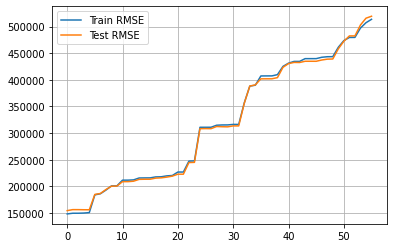

In [ ]:
# Run Linear Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
        
print('Dropped Features --> ',DROP)

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

In [ ]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Testing set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Testing set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Testing set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()




<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


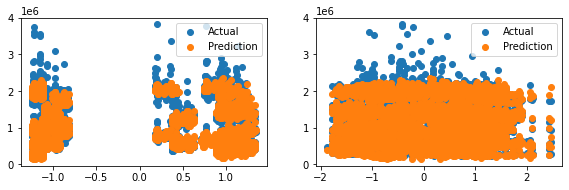



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9328296106281632
Residual Sum of Squares (RSS) on Training set  ---> 103518718391842.16
Mean Squared Error (MSE) on Training set       ---> 21738496092.365005
Root Mean Squared Error (RMSE) on Training set ---> 147439.80497940507

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9303017696577067
Residual Sum of Squares (RSS) on Testing set  ---> 28393614754891.715
Mean Squared Error (MSE) on Testing set       ---> 23840146729.548035
Root Mean Squared Error (RMSE) on Testing set ---> 154402.5476782946

--------------------Residual Plots--------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


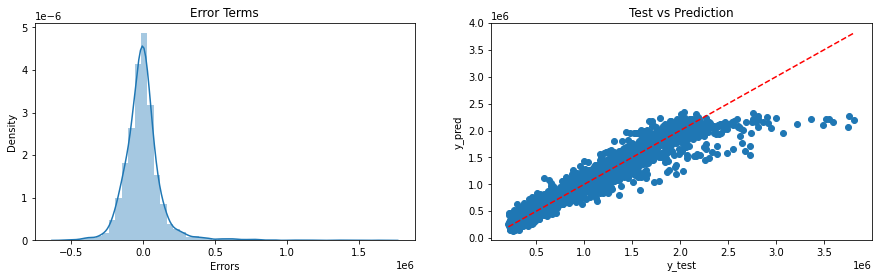

In [ ]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

In [ ]:
print(pred2)

[1478920.69427861 1037744.52934539  868081.35202925 ... 2062177.22659521
 1432598.88657236  538665.72595031]


In [ ]:
print(Test_Y)

52      1606629.58
2426    1092204.79
2232     884042.63
2369     540922.94
3096    2057059.53
           ...    
5408     583079.97
617      307913.58
1745    2182563.66
5075    1629066.90
2000     558473.60
Name: Weekly_Sales, Length: 1191, dtype: float64


<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


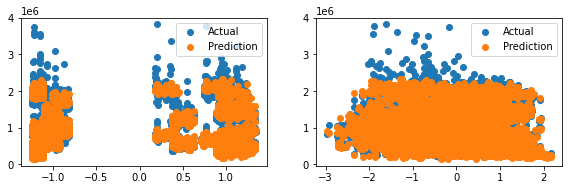



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9327801253729152
Residual Sum of Squares (RSS) on Training set  ---> 103594981909896.22
Mean Squared Error (MSE) on Training set       ---> 21754511110.855988
Root Mean Squared Error (RMSE) on Training set ---> 147494.10534274238

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9304286620592996
Residual Sum of Squares (RSS) on Training set  ---> 28341921419946.79
Mean Squared Error (MSE) on Training set       ---> 23796743425.64802
Root Mean Squared Error (RMSE) on Training set ---> 154261.9312262362

--------------------Residual Plots--------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



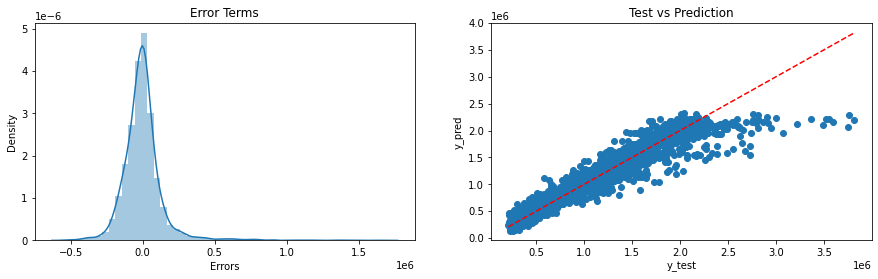

In [ ]:
from sklearn.linear_model import Ridge

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.090e+13, tolerance: 1.541e+11
  model = cd_fast.enet_coordinate_descent(


<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


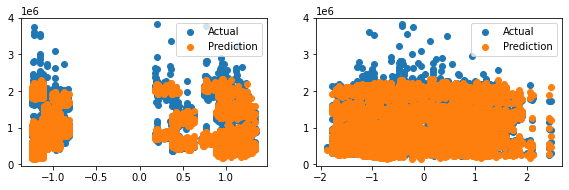



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9327484747343231
Residual Sum of Squares (RSS) on Training set  ---> 103643759854671.89
Mean Squared Error (MSE) on Training set       ---> 21764754274.39561
Root Mean Squared Error (RMSE) on Training set ---> 147528.82523220882

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9304289771466502
Residual Sum of Squares (RSS) on Testing set  ---> 28341793059889.39
Mean Squared Error (MSE) on Testing set       ---> 23796635650.620815
Root Mean Squared Error (RMSE) on Testing set ---> 154261.58190107092

--------------------Residual Plots--------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


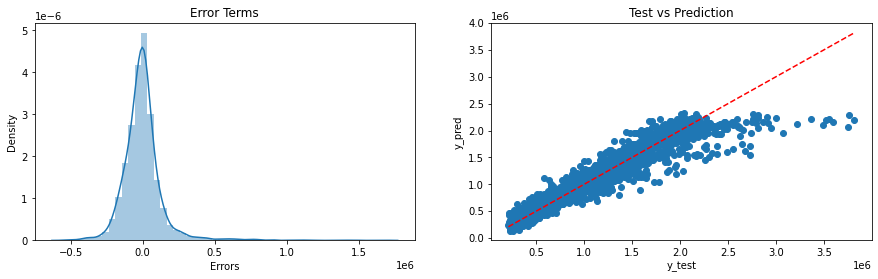

In [ ]:
from sklearn.linear_model import Lasso

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


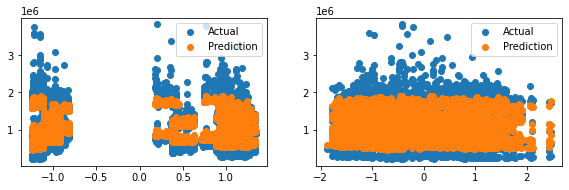



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.8137405142737946
Residual Sum of Squares (RSS) on Training set  ---> 287051235388322.4
Mean Squared Error (MSE) on Training set       ---> 60279553840.470894
Root Mean Squared Error (RMSE) on Training set ---> 245518.94802737908

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.815841056737556
Residual Sum of Squares (RSS) on Testing set  ---> 75022537343948.1
Mean Squared Error (MSE) on Testing set       ---> 62991215234.213356
Root Mean Squared Error (RMSE) on Testing set ---> 250980.5076778142

--------------------Residual Plots--------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


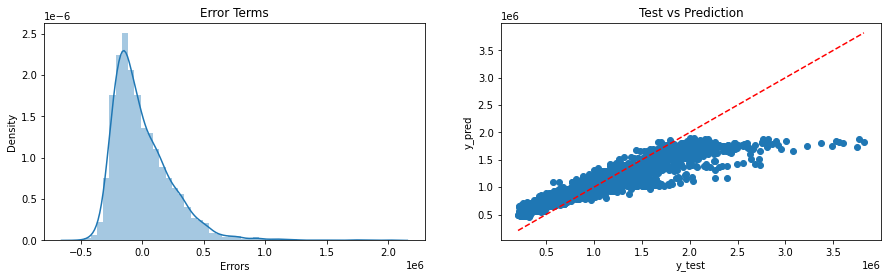

In [ ]:
from sklearn.linear_model import ElasticNet
ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [   3435.79335565  -10914.64725803    4743.1403851   480582.61947728
  -60957.46755428  -30853.06569609  -70053.06421042    5298.18798047
  -11439.58286696  -13971.09128277  -16682.38674897  -12878.73710242
   -2292.83208474   28688.66514407   20184.61268466   20988.70814859
   22136.91951839   31592.44847738   19045.48814114   24450.25914354
   12307.58606646   16964.13937984   41316.13527305   62408.71207801
   55223.44198641 -184149.60630621  217287.3296298  -191432.43688823
   -9300.07974756 -105821.4808743  -120951.75707304 -163526.10852509
  217950.50398171  -40433.22685236   39645.7444887   223055.62594847
  131867.72296706    8382.11323863 -129777.84828955   51459.25405504
   87968.22878722  133612.12244756   93290.45823604 -121281.87572729
   67461.22478578   87415.76570356  124035.8303268  -125925.7954409

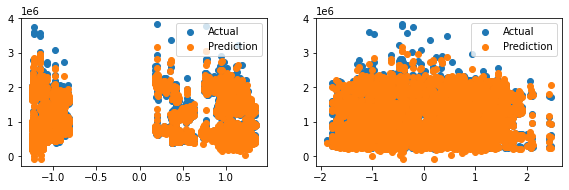



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9791183107579071
Residual Sum of Squares (RSS) on Training set  ---> 32181527134402.742
Mean Squared Error (MSE) on Training set       ---> 6757985538.513805
Root Mean Squared Error (RMSE) on Training set ---> 82206.96770051676

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -2.6662931277397167e+21
Residual Sum of Squares (RSS) on Testing set  ---> 1.0861925693214927e+36
Mean Squared Error (MSE) on Testing set       ---> 9.120004780197251e+32
Root Mean Squared Error (RMSE) on Testing set ---> 3.0199345655489372e+16

--------------------Residual Plots--------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


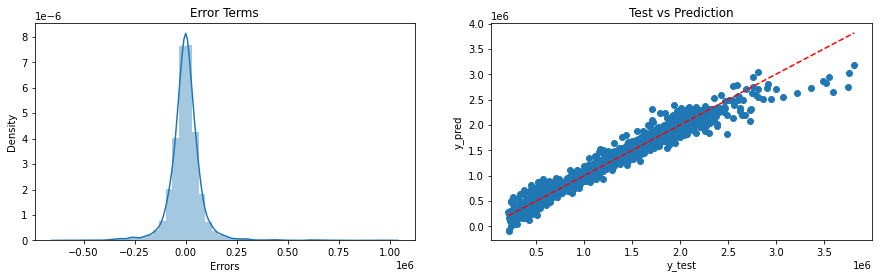

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

Epoch 1/100
38/38 - 29s - loss: 1421082361856.0000 - 29s/epoch - 773ms/step
Epoch 2/100
38/38 - 27s - loss: 1421064273920.0000 - 27s/epoch - 722ms/step
Epoch 3/100
38/38 - 25s - loss: 1421054050304.0000 - 25s/epoch - 670ms/step
Epoch 4/100
38/38 - 26s - loss: 1421043695616.0000 - 26s/epoch - 671ms/step
Epoch 5/100
38/38 - 26s - loss: 1421033996288.0000 - 26s/epoch - 671ms/step
Epoch 6/100
38/38 - 26s - loss: 1421023510528.0000 - 26s/epoch - 675ms/step
Epoch 7/100
38/38 - 26s - loss: 1421013286912.0000 - 26s/epoch - 677ms/step
Epoch 8/100
38/38 - 26s - loss: 1421003456512.0000 - 26s/epoch - 674ms/step
Epoch 9/100
38/38 - 26s - loss: 1420993363968.0000 - 26s/epoch - 680ms/step
Epoch 10/100
38/38 - 26s - loss: 1420983402496.0000 - 26s/epoch - 675ms/step
Epoch 11/100
38/38 - 26s - loss: 1420973572096.0000 - 26s/epoch - 672ms/step
Epoch 12/100
38/38 - 25s - loss: 1420963741696.0000 - 25s/epoch - 671ms/step
Epoch 13/100
38/38 - 26s - loss: 1420953911296.0000 - 26s/epoch - 673ms/step
Epoch 14

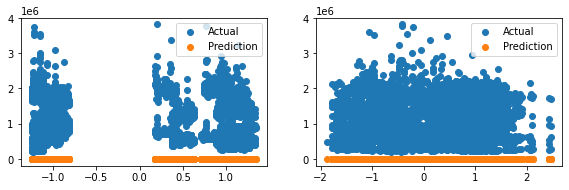



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> -3.387991881478619
Residual Sum of Squares (RSS) on Training set  ---> 6762493118358014.0
Mean Squared Error (MSE) on Training set       ---> 1420095152952.1238
Root Mean Squared Error (RMSE) on Training set ---> 1191677.4534042857

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -3.3096492848236148
Residual Sum of Squares (RSS) on Testing set  ---> 1755661814095207.2
Mean Squared Error (MSE) on Testing set       ---> 1474107316620.6611
Root Mean Squared Error (RMSE) on Testing set ---> 1214128.2125956307

--------------------Residual Plots--------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


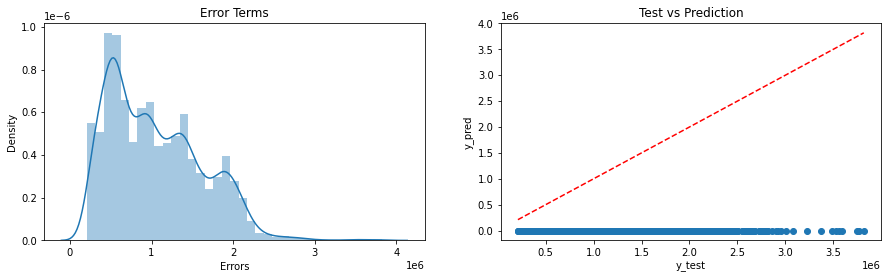

In [ ]:
import tensorflow as tf                 # acts as the framework upon which this model is built
from tensorflow import keras            #defines layers and functions in the model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



Train_X_std1 = Train_X_std.values.reshape(Train_X_std.shape[0], Train_X_std.shape[1],1)
Test_X_std1 = Test_X_std.values.reshape(Test_X_std.shape[0], Test_X_std.shape[1],1)

model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (Train_X_std1.shape[1], 1)))
model.add(LSTM(128,input_shape = (Train_X_std1.shape[1], 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(Train_X_std1, Train_Y, epochs = 100, batch_size = 128, verbose = 2, shuffle = False)



#model = Sequential()
##return_sequences = True allows us to build multi-layer NNs
#model.add(LSTM(128, activation='relu', input_shape=(68,1)))
##Dense determines how many outputs come from our NN
#model.add(Dense(1))
#model.compile(loss='mse', optimizer = 'adam', metrics = ['acc'])
#Fit Network
#model.fit(Train_X_std1, Train_Y, batch_size=16,
#           epochs = 100,
#           verbose=1,
#           shuffle =False)

pred1 = model.predict(Train_X_std1)
pred2 = model.predict(Test_X_std1)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)


Evaluate(5, pred1.reshape(-1), pred2.reshape(-1))

In [ ]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)', 'LSTM']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.932830,9.303018e-01,1.035187e+14,2.839361e+13,2.173850e+10,2.384015e+10,1.474398e+05,1.544025e+05
Ridge Linear Regression (RLR),0.932780,9.304287e-01,1.035950e+14,2.834192e+13,2.175451e+10,2.379674e+10,1.474941e+05,1.542619e+05
Lasso Linear Regression (LLR),0.932748,9.304290e-01,1.036438e+14,2.834179e+13,2.176475e+10,2.379664e+10,1.475288e+05,1.542616e+05
Elastic-Net Regression (ENR),0.813741,8.158411e-01,2.870512e+14,7.502254e+13,6.027955e+10,6.299122e+10,2.455189e+05,2.509805e+05
Polynomial Regression (PNR),0.979118,-2.666293e+21,3.218153e+13,1.086193e+36,6.757986e+09,9.120005e+32,8.220697e+04,3.019935e+16
LSTM,-3.391062,-3.312580e+00,6.767225e+15,1.756856e+15,1.421089e+12,1.475110e+12,1.192094e+06,1.214541e+06


# R2 Score

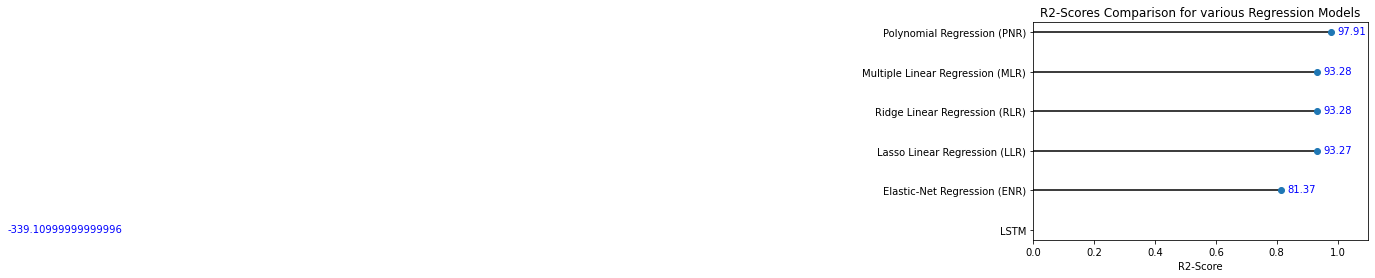

In [ ]:
R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

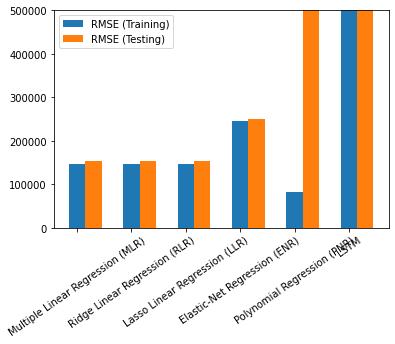

In [ ]:
# RMSE 

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=6

plt.bar(np.arange(6), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(6)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(6),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,500000])
plt.show()